In [1]:
#Importing the required packages
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn import metrics
from sklearn.neighbors import KNeighborsRegressor
import sklearn.tree as st
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
import xgboost as xgb 
import statsmodels.formula.api as smf
import patsy
import matplotlib.ticker as ticker
import sklearn.ensemble as se

In [2]:
#Reading the File
df = pd.read_csv(r"C:\Users\yasha\Desktop\Semester 2\ML\Project\recs2015_public_v4.csv")

In [3]:
#Shape Information of the Dataset
df.shape

(5686, 759)

In [4]:
#Number of Numerical and Categorical columns in the Dataset
numerical_feats = df.dtypes[df.dtypes != "object"].index
print("Number of Numerical features: ", len(numerical_feats))

categorical_feats = df.dtypes[df.dtypes == "object"].index
print("Number of Categorical features: ", len(categorical_feats))

Number of Numerical features:  755
Number of Categorical features:  4


In [5]:
#Removing imputation flag columns and other redundant columns
df = df.loc[:,~ df.columns.str.startswith('Z')]
df = df.loc[:,~ df.columns.str.startswith('BRR')]

In [6]:
#Filtering out some columns based on domain knowledge
df1 = df.filter(items =['DOEID', 'REGIONC', 'DIVISION', 'METROMICRO', 'UATYP10', 'TYPEHUQ', 'UGASHERE', 'STORIES', 'TOTROOMS', 'POOL', 'FUELPOOL', 'RECBATH', 'FUELTUB', 'NUMFRIG', 'SIZRFRI1', 'NUMFREEZ', 'STOVEN', 'STOVENFUEL', 'DUALCOOKTFUEL', 'DUALOVENFUEL', 'COOKTUSE', 'OVENUSE', 'STOVE', 'STOVEFUEL', 'SEPCOOKTUSE', 'OVEN', 'OVENFUEL', 'SEPOVENUSE', 'MICRO', 'AMTMICRO', 'NUMMEAL', 'DISHWASH', 'DWASHUSE', 'DWCYCLE', 'TVCOLOR', 'EQUIPM', 'FUELHEAT', 'AIRCOND', 'FUELH2O', 'FUELH2O2', 'SMARTTHERM', 'NOHEATBROKE', 'NOHEATEL', 'NOHEATNG', 'NOHEATBULK', 'NOACBROKE', 'NOACEL', 'USEEL', 'ELWARM', 'ELCOOL', 'ELWATER', 'ELFOOD', 'ELOTHER', 'CLIMATE_REGION_PUB','IECC_CLIMATE_PUB', 'KWHSPH', 'KWHCOL', 'KWHWTH', 'KWHRFG', 'KWHRFG1', 'KWHRFG2', 'KWHFRZ', 'KWHCOK', 'KWHMICRO', 'KWHCW', 'KWHCDR', 'KWHDWH', 'KWHLGT', 'KWHTVREL', 'KWHTV1', 'KWHTV2', 'KWHAHUHEAT', 'KWHAHUCOL', 'KWHEVAPCOL', 'KWHCFAN', 'KWHDHUM', 'KWHHUM', 'KWHPLPMP', 'KWHHTBPMP', 'KWHHTBHEAT', 'KWHNEC', 'DOLLAREL', 'DOLELSPH', 'DOLELCOL', 'DOLELWTH', 'DOLELRFG', 'DOLELRFG1', 'DOLELRFG2', 'DOLELFRZ', 'DOLELCOK', 'DOLELMICRO', 'DOLELCW', 'DOLELCDR', 'DOLELDWH', 'DOLELLGT', 'DOLELTVREL', 'DOLELTV1', 'DOLELTV2', 'DOLELAHUHEAT', 'DOLELAHUCOL', 'DOLELEVAPCOL', 'DOLELCFAN', 'DOLELDHUM', 'DOLELHUM', 'DOLELPLPMP', 'DOLELHTBPMP', 'DOLELHTBHEAT', 'DOLELNEC', 'INTERNET', 'SMARTMETER', 'INTDATA', 'INTDATAACC', 'INWIRELESS', 'KWH'])

In [7]:
#Excluding object columns
df2 = df1.select_dtypes(exclude=['object'])
df2 = df2.dropna(axis=0)

In [8]:
#First Round of VIF 
pd.DataFrame({'variables':df2.columns[1:], 'VIF':[variance_inflation_factor(df2.values, i+1) for i in range(len(df2.columns[1:]))]})


C:\Users\yasha\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\Users\yasha\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


,variables,VIF
0,REGIONC,1.268316e+01
1,DIVISION,1.273892e+01
2,TYPEHUQ,2.098140e+00
3,UGASHERE,1.747043e+00
4,STORIES,1.862829e+00
...,...,...
104,SMARTMETER,2.734947e+00
105,INTDATA,7.633741e+00
106,INTDATAACC,6.599345e+00
107,INWIRELESS,1.245281e+01


In [9]:
df2.corr()

,DOEID,REGIONC,DIVISION,TYPEHUQ,UGASHERE,STORIES,TOTROOMS,POOL,FUELPOOL,RECBATH,...,DOLELPLPMP,DOLELHTBPMP,DOLELHTBHEAT,DOLELNEC,INTERNET,SMARTMETER,INTDATA,INTDATAACC,INWIRELESS,KWH
DOEID,1.000000,-0.004010,-0.002920,0.014811,0.030000,0.009707,0.028997,0.019761,-0.004123,0.016074,...,0.028610,0.015528,0.011834,0.010581,0.021775,-0.028674,-0.016615,-0.023657,0.023042,-0.023818
REGIONC,-0.004010,1.000000,0.950294,-0.047589,0.009752,-0.083759,-0.037154,-0.002219,0.027276,0.055221,...,0.022171,0.039233,0.016032,-0.006853,-0.016463,-0.024115,-0.030080,-0.028036,-0.027891,0.045439
DIVISION,-0.002920,0.950294,1.000000,-0.020586,0.058142,-0.091452,-0.065924,-0.003712,0.016149,0.065091,...,0.021341,0.050359,0.021661,0.004668,-0.009770,-0.015121,-0.022279,-0.022841,-0.019867,-0.007357
TYPEHUQ,0.014811,-0.047589,-0.020586,1.000000,0.069603,-0.537226,-0.522306,-0.139105,-0.070360,-0.109792,...,-0.119220,-0.070991,-0.061421,-0.091072,-0.072199,-0.110065,-0.074362,-0.076673,-0.083476,-0.368728
UGASHERE,0.030000,0.009752,0.058142,0.069603,1.000000,0.049905,0.017009,-0.016866,0.009512,0.005206,...,-0.018773,0.000791,-0.028866,0.058044,0.044192,-0.038676,-0.041529,-0.042890,0.053315,-0.301142
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SMARTMETER,-0.028674,-0.024115,-0.015121,-0.110065,-0.038676,0.055783,0.054468,0.018393,0.014290,0.016464,...,0.009130,0.019475,0.023273,0.013809,-0.009410,1.000000,0.786780,0.746294,-0.012288,0.047554
INTDATA,-0.016615,-0.030080,-0.022279,-0.074362,-0.041529,0.028902,0.026217,0.000562,0.005585,0.006325,...,-0.007987,0.016277,0.024998,0.008506,-0.016236,0.786780,1.000000,0.916772,-0.021432,0.035818
INTDATAACC,-0.023657,-0.028036,-0.022841,-0.076673,-0.042890,0.005668,0.016727,-0.007108,0.000252,-0.002234,...,-0.015053,0.007209,0.016552,-0.001244,-0.049649,0.746294,0.916772,1.000000,-0.056289,0.024695
INWIRELESS,0.023042,-0.027891,-0.019867,-0.083476,0.053315,0.184178,0.236426,0.096993,0.048775,0.093537,...,0.093580,0.070835,0.060926,0.097463,0.955841,-0.012288,-0.021432,-0.056289,1.000000,0.143528


In [10]:
#Dropping some columns with no correlation based on correlation matrix
df2=df2.drop (columns = ["DIVISION","INWIRELESS","DOLELPLPMP","TYPEHUQ"], axis = 1)
#removing dol columns from data
df2 = df2[df2.columns[~df2.columns.str.startswith("DOLE")]]
#removing dol columns from data
df2 = df2[df2.columns[~df2.columns.str.startswith("DOL")]]
#removing kwh columns from data
df2 = df2[df2.columns[~df2.columns.str.startswith("KWH")]]
#removing doe columns from data
df2 = df2[df2.columns[~df2.columns.str.startswith("DOE")]]

In [11]:
#Second round of VIF
pd.DataFrame({'variables':df2.columns[1:], 'VIF':[variance_inflation_factor(df2.values, i+1) for i in range(len(df2.columns[1:]))]})


C:\Users\yasha\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\Users\yasha\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


,variables,VIF
0,UGASHERE,1.670923
1,STORIES,1.508313
2,TOTROOMS,1.959167
3,POOL,1.876370
4,FUELPOOL,1.743180
5,RECBATH,2.801218
6,FUELTUB,2.716320
7,NUMFRIG,1.425944
8,SIZRFRI1,1.206572
9,NUMFREEZ,1.138292


### Creating Dummy Variables

In [12]:
#Getting dummy variables for NUMMEAL
dummies_NumMeal = pd.get_dummies(df2['NUMMEAL'])

#Renaming the dummy variable columns
dummies_NumMeal.columns = ['Meals 3 or more a day', 'Meals 2 times a day','Meals once a day', 'Meals few times a week', 'Meals once a week', 'Meals less than a week', 'Never']

#Reseting index and dropping original column
dummies_NumMeal.reset_index(drop=True, inplace=True)
df2.reset_index(drop=True, inplace=True)
df2 =df2.drop(['NUMMEAL'], axis = 1)

#Combining with main Dataframe 
df2['NUMMEAL_Meal3ormore']=dummies_NumMeal['Meals 3 or more a day']
df2['NUMMEAL_Meal2']=dummies_NumMeal['Meals 2 times a day']
df2['NUMMEAL_Mealonceday']=dummies_NumMeal['Meals once a day']
df2['NUMMEAL_Mealfwtimeweek']=dummies_NumMeal['Meals few times a week']
df2['NUMMEAL_Mealonceweek']=dummies_NumMeal['Meals once a week']
df2['NUMMEAL_Mealslessweek']=dummies_NumMeal['Meals less than a week']
df2['NUMMEAL_Never']=dummies_NumMeal['Never']

In [13]:
#Getting dummy variables for DWCYCLE
dummies_DWCycle = pd.get_dummies(df2['DWCYCLE'])

#Renaming the dummy variable columns
dummies_DWCycle.columns = ['Normal or default cycle without heated dry', 'Normal or default cycle with heated dry','Heavy or “pots and pans” cycle', 'Light or delicate cycle', 'Energy saver', 'NA_DWC']

#Reseting index and dropping original column
dummies_DWCycle.reset_index(drop=True, inplace=True)
df2.reset_index(drop=True, inplace=True)
df2 =df2.drop(['DWCYCLE'], axis = 1)

#Combining with main Dataframe 
df2['DWCYCLE_NormCywoHDry']=dummies_DWCycle['Normal or default cycle without heated dry']
df2['DWCYCLE_NormCywHDry']=dummies_DWCycle['Normal or default cycle with heated dry']
df2['DWCYCLE_HCycle']=dummies_DWCycle['Heavy or “pots and pans” cycle']
df2['DWCYCLE_LCycle']=dummies_DWCycle['Light or delicate cycle']
df2['DWCYCLE_ESav']=dummies_DWCycle['Energy saver']
df2['DWCYCLE_NA']=dummies_DWCycle['NA_DWC']

In [14]:
#Getting dummy variables for EQUIPM
dummies_EquipM = pd.get_dummies(df2['EQUIPM'])

#Renaming the dummy variable columns 
dummies_EquipM.columns = ['Steam/hot water system with radiators or pipes', 'Central furnace','Heat pump', 'Built-in electric units installed in walls, ceilings, baseboards, or floors', 'Built-in floor/wall pipeless furnace', 'Built-in room heater burning gas, oil, or kerosene', 'Wood-burning stove (cordwood or pellets)', 'Fireplace', 'Portable electric heaters', 'Some other equipment', 'NA_EQM']

#Reseting index and dropping original column
dummies_EquipM.reset_index(drop=True, inplace=True)
df2.reset_index(drop=True, inplace=True) 
df2 =df2.drop(['EQUIPM'], axis = 1)

#Combining with the main Dataframe 
df2['EQUIPM_Steam']=dummies_EquipM['Steam/hot water system with radiators or pipes']
df2['EQUIPM_Furnace']=dummies_EquipM['Central furnace']
df2['EQUIPM_HPump']=dummies_EquipM['Heat pump']
df2['EQUIPM_BIElectricUnits']=dummies_EquipM['Built-in electric units installed in walls, ceilings, baseboards, or floors']
df2['EQUIPM_BIPFurnace']=dummies_EquipM['Built-in floor/wall pipeless furnace']
df2['EQUIPM_BIRoomHeater']=dummies_EquipM['Built-in room heater burning gas, oil, or kerosene']
df2['EQUIPM_WoodStove']=dummies_EquipM['Wood-burning stove (cordwood or pellets)']
df2['EQUIPM_Fireplace']=dummies_EquipM['Fireplace']
df2['EQUIPM_PortEHeat']=dummies_EquipM['Portable electric heaters']
df2['EQUIPM_SOE']=dummies_EquipM['Some other equipment']
df2['EQUIPM_NA']=dummies_EquipM['NA_EQM']

In [15]:
#Getting dummy variables for FUELHEAT
dummies_FH = pd.get_dummies(df2['FUELHEAT'])

#Renaming the dummy variable columns 
dummies_FH.columns = ['Natural gas from underground pipes', 'Propane (bottled gas)', 'Fuel oil/kerosene', 'Electricity', 'Wood (cordwood or pellets)', 'Some other fuel', 'NA_FH']

#Reseting index and dropping original column
dummies_FH.reset_index(drop=True, inplace=True)
df2.reset_index(drop=True, inplace=True) 
df2 = df2.drop(['FUELHEAT'], axis = 1)

#Combining with main Dataframe 
df2['FH_NG']=dummies_FH['Natural gas from underground pipes']
df2['FH_Propane']=dummies_FH['Propane (bottled gas)']
df2['FH_Fuel']=dummies_FH['Fuel oil/kerosene']
df2['FH_Electricity']=dummies_FH['Electricity']
df2['FH_Wood']=dummies_FH['Wood (cordwood or pellets)']
df2['FH_SOF']=dummies_FH['Some other fuel']
df2['FH_NA']=dummies_FH['NA_FH']

In [16]:
#Getting dummy variables for SMARTTHERM
dummies_SmartTherm = pd.get_dummies(df2['SMARTTHERM'])

#Renaming the dummy variable columns 
dummies_SmartTherm.columns = ['ST_Yes', 'ST_No', 'NA_ST', 'DK_ST']

#Reseting index and dropping original column
dummies_SmartTherm.reset_index(drop=True, inplace=True)
df2.reset_index(drop=True, inplace=True) 
df2 =df2.drop(['SMARTTHERM'], axis = 1)

#Combining with main Dataframe 
df2['ST_Yes']=dummies_SmartTherm['ST_Yes']
df2['ST_No']=dummies_SmartTherm['ST_No']
df2['ST_NA']=dummies_SmartTherm['NA_ST']
df2['ST_DK']=dummies_SmartTherm['DK_ST']

In [17]:
#Getting dummy variables for SMMET
dummies_SMMET = pd.get_dummies(df2['SMARTMETER'])

#Renaming the dummy variable columns 
dummies_SMMET.columns = ['SM_Yes', 'SM_No', 'SM_Ref', 'SM_DK']

#Reseting index and dropping original column
dummies_SMMET.reset_index(drop=True, inplace=True)
df2.reset_index(drop=True, inplace=True) 
df2 =df2.drop(['SMARTMETER'], axis = 1)

#Combining with main Dataframe 
df2['SM_Yes']=dummies_SMMET['SM_Yes']
df2['SM_No']=dummies_SMMET['SM_No']
df2['SM_Ref']=dummies_SMMET['SM_Ref']
df2['SM_DK']=dummies_SMMET['SM_DK']

In [18]:
#Getting dummy variables for INTDATA
dummies_INTDATA = pd.get_dummies(df2['INTDATA'])

#Renaming the dummy variable columns 
dummies_INTDATA.columns = ['ID_Yes', 'ID_No', 'ID_NA', 'ID_Ref', 'ID_DK']

#Reseting index and dropping original column
dummies_INTDATA.reset_index(drop=True, inplace=True)
df2.reset_index(drop=True, inplace=True) 
df2 =df2.drop(['INTDATA'], axis = 1)

#Combining with main Dataframe 
df2['ID_Yes']=dummies_INTDATA['ID_Yes']
df2['ID_No']=dummies_INTDATA['ID_No']
df2['ID_NA']=dummies_INTDATA['ID_NA']
df2['ID_Ref']=dummies_INTDATA['ID_Ref']
df2['ID_DK']=dummies_INTDATA['ID_DK']

In [19]:
#Getting dummy variables for INTDATAACC

dummies_IDA = pd.get_dummies(df2['INTDATAACC'])

#Renaming the dummy variable columns 
dummies_IDA.columns = ['IDA_Yes', 'IDA_No', 'IDA_NA', 'IDA_DK']

#Reseting index and dropping original column
dummies_IDA.reset_index(drop=True, inplace=True)
df2.reset_index(drop=True, inplace=True) 
df2 =df2.drop(['INTDATAACC'], axis = 1)

#Combining with main Dataframe 
df2['IDA_Yes']=dummies_IDA['IDA_Yes']
df2['IDA_No']=dummies_IDA['IDA_No']
df2['IDA_NA']=dummies_IDA['IDA_NA'] 

In [20]:
#Dropping one dummy value each to avoid a dummy loop
df2 =df2.drop(['NUMMEAL_Meal3ormore', 'DWCYCLE_NormCywoHDry','EQUIPM_Steam','FH_NG','ST_Yes', 'SM_Yes','ID_Yes','IDA_Yes'], axis = 1)

In [21]:
#Getting dummy variables 

dummies_Stories = pd.get_dummies(df2['STORIES'])
dummies_POOL = pd.get_dummies(df2['POOL'])
dummies_FUELPOOL=  pd.get_dummies(df2['FUELPOOL'])
dummies_FUELTUB=  pd.get_dummies(df2['FUELTUB'])
dummies_SIZRFRI1=  pd.get_dummies(df2['SIZRFRI1'])
dummies_STOVENFUEL=  pd.get_dummies(df2['STOVENFUEL'])
dummies_DUALCOOKTFUEL=  pd.get_dummies(df2['DUALCOOKTFUEL'])
dummies_DUALOVENFUEL=  pd.get_dummies(df2['DUALOVENFUEL'])
dummies_STOVEFUEL=  pd.get_dummies(df2['STOVEFUEL'])
dummies_OVENFUEL=  pd.get_dummies(df2['OVENFUEL'])


#Renaming the dummy variable columns 
dummies_Stories.columns = ['one_story', 'two_story','three_story', 'four/x_story', 'split_level_story','storiesnot_app']
dummies_POOL.columns = ['yes_pool','no_pool','notapp_pool']
dummies_FUELPOOL.columns = ['natural_pool', 'propane_pool', 'fuel_pool', 'ele_pool', 'solar_pool', 'NA_pool']
dummies_FUELTUB.columns= ['natural_TUB','propane_TUB','ele_TUB','solar_TUB','otherfuel_TUB','fuelnotapp_TUB']
dummies_SIZRFRI1.columns= ['halfsize_fri','small_fri','medium_fri','large_fri','verylarde_fri', 'notapp_fri']
dummies_STOVENFUEL.columns= ['natural_sto','propane_sto','ele_sto','dual_sto','otherfuel_sto','fuelnotapp_sto']
dummies_DUALCOOKTFUEL.columns= ['natural_dualcook','propane_dualcook','ele_dualcook','fuelnotapp_dualcook']
dummies_DUALOVENFUEL.columns=['natural_dualoven','ele_dualoven','fuelnotapp_dualoven']
dummies_STOVEFUEL.columns= ['natural_stov','propane_stov','ele_stov','fuelnotapp_stov']
dummies_OVENFUEL.columns= ['natural_OF','propane_OF','ele_OF','otherfuel_OF','fuelnotapp_OF']

#Combining with the main Dataframe

#STORIES
df2['one_story']= dummies_Stories['one_story']
df2['two_story']= dummies_Stories['two_story']
df2['three_story' ]= dummies_Stories['three_story' ]
df2['four/x_story']= dummies_Stories['four/x_story']
df2[ 'split_level_story']= dummies_Stories[ 'split_level_story']
df2['not_app_stories']= dummies_Stories['storiesnot_app']

#POOL
df2 ['yes_pool']  = dummies_POOL['yes_pool']
df2 ['no_pool']  = dummies_POOL['no_pool']
df2['notapp_pool']  = dummies_POOL['notapp_pool']

#FUELPOOL
df2['natural_pool']= dummies_FUELPOOL['natural_pool']
df2['propane_pool']= dummies_FUELPOOL['propane_pool']
df2['fuel_pool']= dummies_FUELPOOL['fuel_pool']
df2['ele_pool']= dummies_FUELPOOL['ele_pool']
df2['solar_pool']= dummies_FUELPOOL['solar_pool']
df2['NA_pool']= dummies_FUELPOOL['NA_pool']

#FUELTUB
df2['natural_TUB']= dummies_FUELTUB['natural_TUB']
df2['propane_TUB']= dummies_FUELTUB['propane_TUB']
df2['ele_TUB']= dummies_FUELTUB['ele_TUB']
df2['solar_TUB']= dummies_FUELTUB['solar_TUB']
df2['otherfuel_TUB']= dummies_FUELTUB['otherfuel_TUB']
df2['fuelnotapp_TUB']= dummies_FUELTUB['fuelnotapp_TUB']

#SIZRFRI1
df2['halfsize_fri']= dummies_SIZRFRI1['halfsize_fri']
df2['small_fri']= dummies_SIZRFRI1['small_fri']
df2['medium_fri']= dummies_SIZRFRI1['medium_fri']
df2['large_fri']= dummies_SIZRFRI1['large_fri']
df2['verylarde_fri']= dummies_SIZRFRI1['verylarde_fri']
df2['notapp_fri']= dummies_SIZRFRI1['notapp_fri']

#STOVENFUEL
df2['natural_sto']= dummies_STOVENFUEL['natural_sto']
df2['propane_sto']= dummies_STOVENFUEL['propane_sto']
df2['ele_sto']= dummies_STOVENFUEL['ele_sto']
df2['solar_sto']= dummies_STOVENFUEL['dual_sto']
df2['otherfuel_sto']= dummies_STOVENFUEL['otherfuel_sto']
df2['fuelnotapp_sto']= dummies_STOVENFUEL['fuelnotapp_sto']

#DUALCOOKTFUEL
df2['natural_dualcook']= dummies_DUALCOOKTFUEL['natural_dualcook']
df2['propane_dualcook']= dummies_DUALCOOKTFUEL['propane_dualcook']
df2['ele_dualcook']= dummies_DUALCOOKTFUEL['ele_dualcook']
df2['fuelnotapp_dualcook']= dummies_DUALCOOKTFUEL['fuelnotapp_dualcook']

#DUALOVENFUEL
df2['natural_dualoven']= dummies_DUALOVENFUEL['natural_dualoven']
df2['ele_dualoven']= dummies_DUALOVENFUEL['ele_dualoven']
df2['fuelnotapp_dualoven']= dummies_DUALOVENFUEL['fuelnotapp_dualoven']

#STOVEFUEL
df2['natural_stov']= dummies_STOVEFUEL['natural_stov']
df2['propane_stov']= dummies_STOVEFUEL['propane_stov']
df2['ele_stov']= dummies_STOVEFUEL['ele_stov']
df2['fuelnotapp_stov']= dummies_STOVEFUEL['fuelnotapp_stov']

#OVENFUEL
df2['natural_OF']= dummies_OVENFUEL['natural_OF']
df2['propane_OF']= dummies_OVENFUEL['propane_OF']
df2['ele_OF']= dummies_OVENFUEL['ele_OF']
df2['otherfuel_OF']= dummies_OVENFUEL['otherfuel_OF']
df2['fuelnotapp_OF']= dummies_OVENFUEL['fuelnotapp_OF']



#Resetting index and dropping original columns
df2=df2.drop(['STORIES', ], axis = 1)
df2=df2.drop(['FUELPOOL', ], axis = 1)
df2 =df2.drop(['POOL', ], axis = 1)
df2 =df2.drop(['FUELTUB', ], axis = 1)
df2 =df2.drop(['SIZRFRI1', ], axis = 1)
df2 =df2.drop(['STOVENFUEL', ], axis = 1)
df2 =df2.drop(['DUALCOOKTFUEL', ], axis = 1)
df2 =df2.drop(['DUALOVENFUEL', ], axis = 1)
df2 =df2.drop(['STOVEFUEL', ], axis = 1)
df2 =df2.drop(['OVENFUEL', ], axis = 1)
df2.reset_index(drop=True, inplace=True) 

In [22]:
#Dropping one dummy value each to avoid a dummy loop
df2 =df2.drop(['natural_OF', 'natural_stov','natural_dualoven','natural_sto','natural_dualcook', 'halfsize_fri','natural_TUB','natural_pool','yes_pool','one_story'], axis = 1)

In [23]:
df2['KWH'] = df['KWH']
df3 = pd.get_dummies(df2,columns=['REGIONC'], drop_first=True)

In [24]:
df3 = df2.drop(df2[df2['KWH']>=50000].index)
df3 = df2.drop(df2[df2['NUMFRIG']>=4].index)
df3 = df2.drop(df2[df2['NUMFRIG']==0].index)
df3 = df3.drop(columns = ["REGIONC"], axis = 1)

In [25]:
#Creating Initial data for splitting
X = df3.drop(columns = ["KWH"], axis = 1)
y = df3["KWH"]

In [26]:
#Splitting data into 80% train and 20% test data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=25)

### Prediction Model 1: Random Forest Regressor

In [27]:
#Importing and initializing Random Forest Regression model
rf = se.RandomForestRegressor(n_estimators=100, random_state=25)
rf.fit(X_train, y_train)

RandomForestRegressor(random_state=25)

In [28]:
#Calculating R squared for train and test data
print("R squared of the Linear Regression on training set: {:.2%}".format(rf.score(X_train, y_train)))
print("R squared of the Linear Regression on test set: {:.2%}".format(rf.score(X_test, y_test)))

R squared of the Linear Regression on training set: 93.22%
R squared of the Linear Regression on test set: 47.99%


<AxesSubplot:xlabel='KWH'>

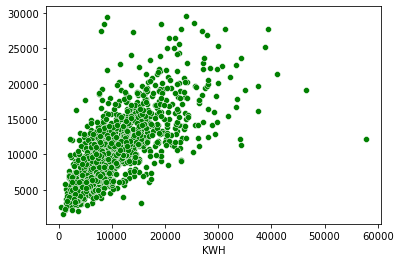

In [29]:
#Predicting test data
y_pred2 = rf.predict(X_test)
sns.scatterplot(x=y_test , y=y_pred2, color="green")

In [30]:
d = {'true': y_test, 'predicted': y_pred2}
df_lr = pd.DataFrame(data=d)
df_lr['diff'] = df_lr['predicted']-df_lr['true']
df_lr

,true,predicted,diff
4538,15660.694,11211.17087,-4449.52313
1458,22464.928,18187.90898,-4277.01902
5586,6426.433,5716.06881,-710.36419
45,3104.036,9057.76525,5953.72925
648,5451.222,6320.74565,869.52365
...,...,...,...
1563,5235.000,4883.65441,-351.34559
4785,4480.097,8649.96429,4169.86729
1975,7700.000,11778.72993,4078.72993
1361,12786.752,11202.63955,-1584.11245


In [31]:
#Calculating metrics
print('MAE:', metrics.mean_absolute_error(y_test,y_pred2))
print('MSE:', metrics.mean_squared_error(y_test,y_pred2))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test,y_pred2)))

MAE: 3541.5642839787797
MSE: 25497200.872766085
RMSE: 5049.475306679506


In [32]:
#Calculating Accuracy
print("Mean Squared Log Error of the Random Forest on test set is {:.2%}".format(metrics.mean_squared_log_error(y_test,y_pred2)))
print("Accuracy {:.2%}".format(1-metrics.mean_squared_log_error(y_test,y_pred2)))

Mean Squared Log Error of the Random Forest on test set is 20.26%
Accuracy 79.74%


### Prediction Model 2: KNN Regressor

In [33]:
#Importing and initializing Knn Regression model
knn = KNeighborsRegressor()
knn.fit(X_train, y_train)

KNeighborsRegressor()

In [34]:
#Calculating R squared for train and test data
print("R squared of the Random Forest Regressor on training set: {:.2%}".format(knn.score(X_train, y_train)))
print("R squared of the Random Forest Regressor on test set: {:.2%}".format(knn.score(X_test, y_test)))

R squared of the Random Forest Regressor on training set: 54.20%
R squared of the Random Forest Regressor on test set: 29.09%


<AxesSubplot:xlabel='KWH'>

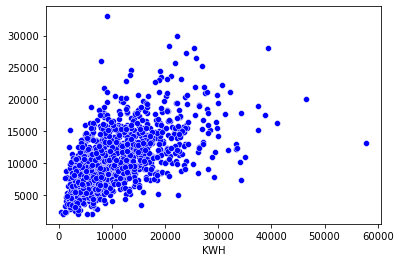

In [35]:
#Predicting test data
y_pred3 = knn.predict(X_test)
sns.scatterplot(x=y_test , y=y_pred3, color="blue")

In [36]:
p = {'true': y_test, 'predicted': y_pred3}
pf_knn = pd.DataFrame(data=p)
pf_knn['diff'] = pf_knn['predicted']-pf_knn['true']
pf_knn

,true,predicted,diff
4538,15660.694,10929.4786,-4731.2154
1458,22464.928,5021.6452,-17443.2828
5586,6426.433,4562.7986,-1863.6344
45,3104.036,10606.1722,7502.1362
648,5451.222,5537.1212,85.8992
...,...,...,...
1563,5235.000,8866.4862,3631.4862
4785,4480.097,6699.2632,2219.1662
1975,7700.000,9298.0946,1598.0946
1361,12786.752,13038.9428,252.1908


In [37]:
#Calculating metrics
print('MAE:', metrics.mean_absolute_error(y_test,y_pred3))
print('MSE:', metrics.mean_squared_error(y_test,y_pred3))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test,y_pred3)))

MAE: 4291.325557559681
MSE: 34760514.549651206
RMSE: 5895.804826285484


In [38]:
#Calculating Accuracy
print("Mean Squared Log Error of the Random Forest on test set is {:.2%}".format(metrics.mean_squared_log_error(y_test,y_pred3)))
print("Accuracy {:.2%}".format(1-metrics.mean_squared_log_error(y_test,y_pred3)))

Mean Squared Log Error of the Random Forest on test set is 28.68%
Accuracy 71.32%


### Prediction Model 3: Decision Regression

In [39]:
#Importing and initializing Decision Tree Regressor
tree = st.DecisionTreeRegressor(random_state=25)
tree.fit(X_train, y_train)

DecisionTreeRegressor(random_state=25)

In [40]:
#Calculating R squared for train and test data
print("R squared of the Linear Regression on training set: {:.2%}".format(tree.score(X_train, y_train)))
print("R squared of the Linear Regression on test set: {:.2%}".format(tree.score(X_test, y_test)))

R squared of the Linear Regression on training set: 100.00%
R squared of the Linear Regression on test set: -3.08%


<AxesSubplot:xlabel='KWH'>

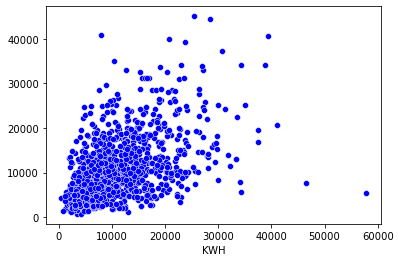

In [41]:
#Predicting test data
y_pred5 = tree.predict(X_test)
sns.scatterplot(x=y_test , y=y_pred5, color="blue")

In [42]:
tti = {'true': y_test, 'predicted': y_pred5}
tti_lr = pd.DataFrame(data=tti)
tti_lr['diff'] = tti_lr['predicted']-tti_lr['true']
tti_lr

,true,predicted,diff
4538,15660.694,10962.130,-4698.564
1458,22464.928,7729.500,-14735.428
5586,6426.433,2588.800,-3837.633
45,3104.036,9037.228,5933.192
648,5451.222,4690.000,-761.222
...,...,...,...
1563,5235.000,4340.000,-895.000
4785,4480.097,13565.211,9085.114
1975,7700.000,13802.004,6102.004
1361,12786.752,15404.000,2617.248


In [43]:
#Calculating metrics
print('MAE:', metrics.mean_absolute_error(y_test,y_pred5))
print('MSE:', metrics.mean_squared_error(y_test,y_pred5))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test,y_pred5)))

MAE: 5112.73756852343
MSE: 50532178.00882111
RMSE: 7108.598878036452


In [44]:
#Calculating Accuracy
print("Mean Squared Log Error of the Random Forest on test set is {:.2%}".format(metrics.mean_squared_log_error(y_test,y_pred5)))
print("Accuracy {:.2%}".format(1-metrics.mean_squared_log_error(y_test,y_pred5)))

Mean Squared Log Error of the Random Forest on test set is 42.25%
Accuracy 57.75%


### Prediction Model 4: Lasso Regression

In [45]:
#Importing and initializing Lasso Regression model
lasso = Lasso()
lasso.fit(X_train, y_train)

Lasso()

In [46]:
#Calculating R squared for train and test data
print("R squared of the Linear Regression on training set: {:.2%}".format(lasso.score(X_train, y_train)))
print("R squared of the Linear Regression on test set: {:.2%}".format(lasso.score(X_test, y_test)))

R squared of the Linear Regression on training set: 55.69%
R squared of the Linear Regression on test set: 49.79%


<AxesSubplot:xlabel='KWH'>

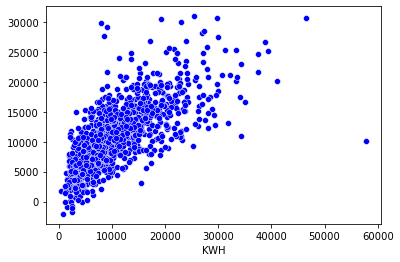

In [47]:
#Predicting test data
y_pred1 = lasso.predict(X_test)
sns.scatterplot(x=y_test , y=y_pred1, color="blue")

In [48]:
l = {'true': y_test, 'predicted': y_pred1}
l_lr = pd.DataFrame(data=l)
l_lr['diff'] = l_lr['predicted']-l_lr['true']
l_lr

,true,predicted,diff
4538,15660.694,14276.639983,-1384.054017
1458,22464.928,23117.623790,652.695790
5586,6426.433,6215.671042,-210.761958
45,3104.036,6172.636248,3068.600248
648,5451.222,6124.433495,673.211495
...,...,...,...
1563,5235.000,7380.671073,2145.671073
4785,4480.097,2703.968571,-1776.128429
1975,7700.000,11226.659604,3526.659604
1361,12786.752,13847.959055,1061.207055


In [49]:
#Calculating metrics 
print('MAE:', metrics.mean_absolute_error(y_test,y_pred1))
print('MSE:', metrics.mean_squared_error(y_test,y_pred1))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test,y_pred1)))

MAE: 3502.9599493761834
MSE: 24615184.276247635
RMSE: 4961.369193705265


In [50]:
#Calculating Accuracy
print("Mean Squared Log Error of the Random Forest on test set is {:.2%}".format(metrics.mean_squared_log_error(y_test,y_pred1)))
print("Accuracy {:.2%}".format(1-metrics.mean_squared_log_error(y_test,y_pred1)))

ValueError: Mean Squared Logarithmic Error cannot be used when targets contain negative values.

In [ ]:
#Plotting prediction to depict negative values 
sns.distplot((y_pred1-y_test),bins=50, color= "blue");

(array([1., 1., 0., 0., 1., 1., 1., 0., 0., 3.]),
 array([-2070.8633624 , -1864.55987651, -1658.25639062, -1451.95290472,
        -1245.64941883, -1039.34593294,  -833.04244705,  -626.73896115,
         -420.43547526,  -214.13198937,    -7.82850347]),
 <BarContainer object of 10 artists>)

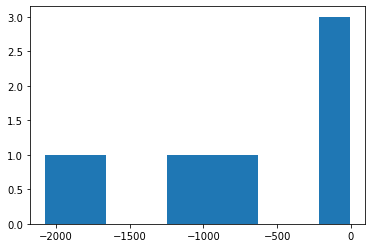

In [51]:
#Plotting prediction to depict negative values
plt.hist(y_pred1[y_pred1 < 0 ])

<b> The lasso regression model will be dropped  due to the negative predicted energy consumption values. </b>

### Prediction Model 5: Ridge Regression

In [52]:
#Importing and initializing Ridge Regression
ridge = Ridge()
ridge.fit(X_train, y_train)

Ridge()

In [53]:
#Calculating R squared for train and test data
print("R squared of the Linear Regression on training set: {:.2%}".format(ridge.score(X_train, y_train)))
print("R squared of the Linear Regression on test set: {:.2%}".format(ridge.score(X_test, y_test)))

R squared of the Linear Regression on training set: 55.71%
R squared of the Linear Regression on test set: 49.67%


<AxesSubplot:xlabel='KWH'>

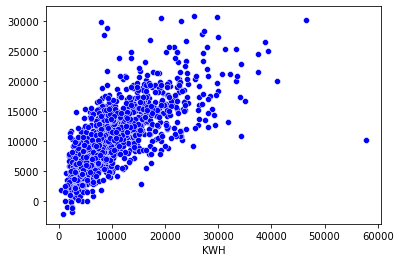

In [54]:
#Predicting on test data
ridge_preds = ridge.predict(X_test)
sns.scatterplot(x=y_test , y=ridge_preds, color="blue")

In [55]:
ri = {'true': y_test, 'predicted': ridge_preds}
ri_ri = pd.DataFrame(data=l)
ri_ri['diff'] = ri_ri['predicted']-ri_ri['true']
ri_ri

,true,predicted,diff
4538,15660.694,14276.639983,-1384.054017
1458,22464.928,23117.623790,652.695790
5586,6426.433,6215.671042,-210.761958
45,3104.036,6172.636248,3068.600248
648,5451.222,6124.433495,673.211495
...,...,...,...
1563,5235.000,7380.671073,2145.671073
4785,4480.097,2703.968571,-1776.128429
1975,7700.000,11226.659604,3526.659604
1361,12786.752,13847.959055,1061.207055


In [56]:
#Calculating metrics
print('MAE:', metrics.mean_absolute_error(y_test, ridge_preds))
print('MSE:', metrics.mean_squared_error(y_test, ridge_preds))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, ridge_preds)))

MAE: 3507.958263464081
MSE: 24672758.929569025
RMSE: 4967.168099588439


In [57]:
#Calculating Accuracy
print("Mean Squared Log Error of the Random Forest on test set is {:.2%}".format(metrics.mean_squared_log_error(y_test,ridge_preds)))
print("Accuracy {:.2%}".format(1-metrics.mean_squared_log_error(y_test,ridge_preds)))

ValueError: Mean Squared Logarithmic Error cannot be used when targets contain negative values.

C:\Users\yasha\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


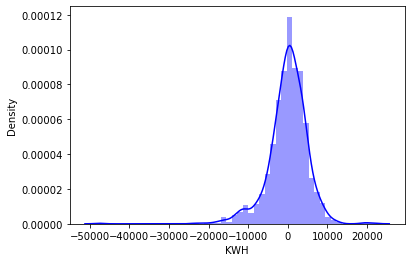

In [58]:
#Plotting prediction to depict negative values 
sns.distplot((ridge_preds-y_test),bins=50, color= "blue");

(array([1., 1., 0., 0., 1., 2., 0., 0., 0., 1.]),
 array([-2072.15910732, -1871.58234921, -1671.00559109, -1470.42883298,
        -1269.85207487, -1069.27531676,  -868.69855864,  -668.12180053,
         -467.54504242,  -266.9682843 ,   -66.39152619]),
 <BarContainer object of 10 artists>)

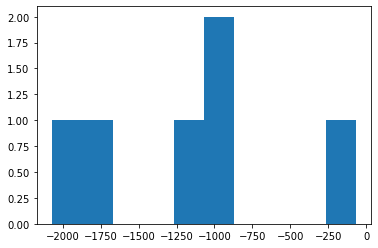

In [59]:
#Plotting prediction to depict negative values
plt.hist(ridge_preds[ridge_preds < 0 ])

<b> The ridge regression model will be dropped due to the negative predicted energy consumption values. </b>

### Prediction Model 6: XG Boost

In [60]:
#Importing and initializing XG Boost
xgboo = xgb.XGBRegressor()
xgboo.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

<AxesSubplot:xlabel='KWH'>

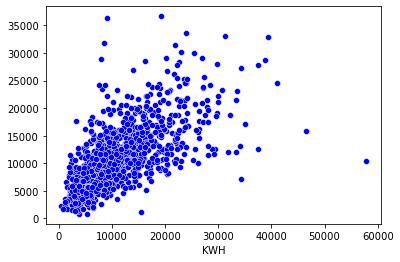

In [61]:
#Predicting on test data
y_pred_xg = xgboo.predict(X_test)
sns.scatterplot(x=y_test , y=y_pred_xg, color="blue")

In [62]:
xb = {'true': y_test, 'predicted': y_pred_xg}
xbxb = pd.DataFrame(data=l)
xbxb['diff'] = xbxb['predicted']-xbxb['true']
xbxb

,true,predicted,diff
4538,15660.694,14276.639983,-1384.054017
1458,22464.928,23117.623790,652.695790
5586,6426.433,6215.671042,-210.761958
45,3104.036,6172.636248,3068.600248
648,5451.222,6124.433495,673.211495
...,...,...,...
1563,5235.000,7380.671073,2145.671073
4785,4480.097,2703.968571,-1776.128429
1975,7700.000,11226.659604,3526.659604
1361,12786.752,13847.959055,1061.207055


In [63]:
#Calculating metrics
print('MAE:', metrics.mean_absolute_error(y_test, y_pred_xg))
print('MSE:', metrics.mean_squared_error(y_test, y_pred_xg))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_xg)))

MAE: 3762.1932488330463
MSE: 29074939.836978633
RMSE: 5392.11830702727


In [64]:
#Calculating Accuracy
print("Mean Squared Log Error of the Random Forest on test set is {:.2%}".format(metrics.mean_squared_log_error(y_test,y_pred_xg)))
print("Accuracy {:.2%}".format(1-metrics.mean_squared_log_error(y_test,y_pred_xg)))

Mean Squared Log Error of the Random Forest on test set is 23.26%
Accuracy 76.74%


C:\Users\yasha\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


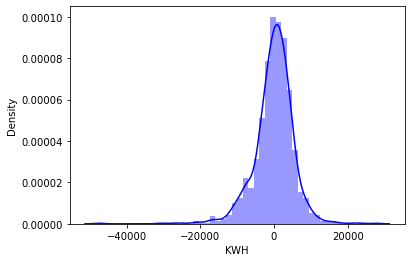

In [65]:
#Plotting prediction to depict negative values 
sns.distplot((y_pred_xg-y_test),bins=50, color= "blue");

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

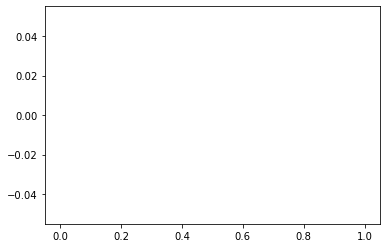

In [66]:
#Plotting prediction to depict negative values
plt.hist(y_pred_xg[y_pred_xg < 0 ])

<b> The XG Boost model will be dropped due to the negative predicted energy consumption values. </b>

### Performance Comparison

In [67]:
#Printing Performance Comparison as a table
perf = pd.DataFrame({"Model":["Random Forest Regressor", "KNN Regressor ", "Decision Regressor", "XG Boost"], 
                     "Accuracy {:.2%}".format:[1-metrics.mean_squared_log_error(y_test,y_pred2), 1-metrics.mean_squared_log_error(y_test,y_pred3), 1-metrics.mean_squared_log_error(y_test,y_pred5), 1-metrics.mean_squared_log_error(y_test,y_pred_xg)]})
perf.rename(columns={ perf.columns[1]: "Accuracy" }, inplace = True)
perf

,Model,Accuracy
0,Random Forest Regressor,0.797426
1,KNN Regressor,0.713164
2,Decision Regressor,0.577542
3,XG Boost,0.767442


### Feature Importance

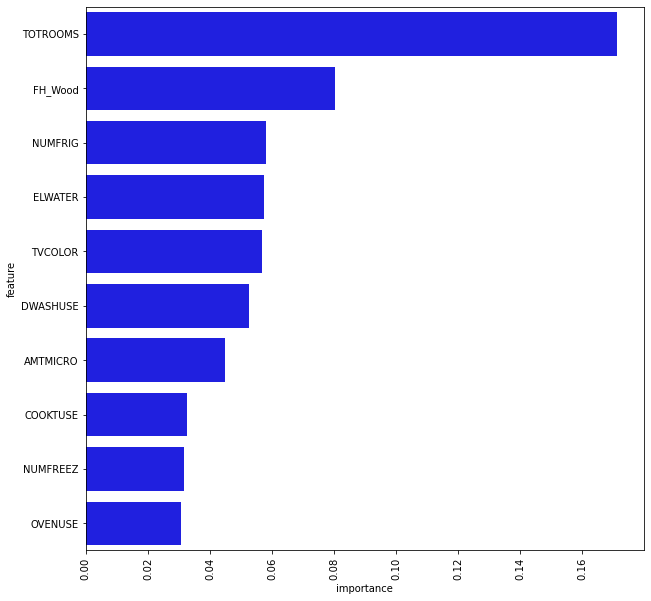

In [68]:
#Top 10 most important features based on best model i.e., Random Forest Regressor
plt.figure(figsize=(10,10))
plot_df = pd.DataFrame({'feature': X_train.columns, 'importance': rf.feature_importances_})
sns.barplot(x='importance', y='feature', data=plot_df.sort_values('importance', ascending=False)[:10],
            color='b')
plt.xticks(rotation=90);

In [77]:
import shap
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test)

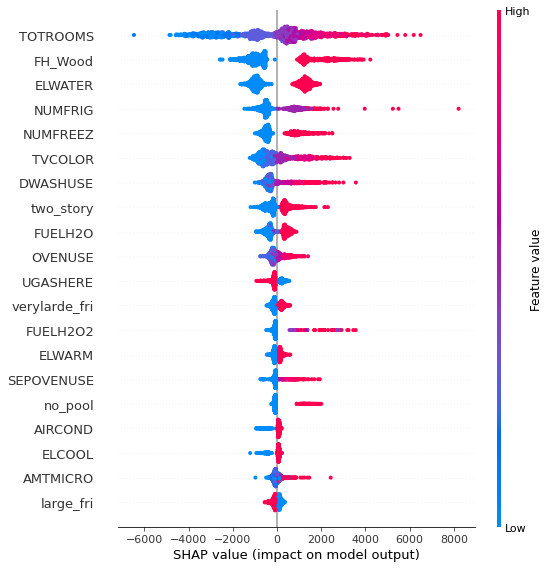

In [78]:
shap.summary_plot(shap_values, X_test)